# Planet to planet low-thrust

In this tutorial we show the use of the {class}`pykep.trajopt.direct_pl2pl` to find a low-thrust trajectory connecting two moving planets. 

The decision vector for this class, compatible with pygmo {cite:p}`pagmo` UDPs (User Defined Problems), is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0$ as a MJD2000, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [1]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

We start defining the problem data.

In [2]:
# Problem data

#####
# ##  Test 1
# mu = pk.MU_SUN
# max_thrust = 0.6
# isp = 3000
# tof = 250.0

# posvel0 = [
#     [34110913367.783306, -139910016918.87585, -14037825669.025244],
#     [29090.9902134693, 10000.390168313803, 1003.3858682643288],
# ]
# posvelf = [
#     [-159018773159.22266, -18832495968.945133, 15781467087.350443],
#     [2781.182556622003, -28898.40730995848, -483.4533989771214],
# ]

# # Define initial and target
# p1 = pk.planet(pk.udpla.keplerian(when=pk.epoch(0), posvel = posvel0, mu_central_body=mu))
# p2 = pk.planet(pk.udpla.keplerian(when=pk.epoch(tof), posvel = posvelf, mu_central_body=mu))

# # Initial state
# ms = 1500.0

# # Number of segments
# nseg = 16


####
## Testcase 2 (less easy, homotopy needed) [Earth-Mars with]
mu = pk.MU_SUN
max_thrust = 0.6
isp = 3000
tof = 550.0

posvel0 = [
    [-125036811000.422, -83670919168.87277, 2610252.8064399767],
    [16081.829029183446, -24868.923007449284, 0.7758272135425942]
]
posvelf = [
    [-169327023332.1986, -161931354587.78766, 763967345.9733696],
    [17656.297796509956, -15438.116653052988, -756.9165272457421]
]

# Define initial and target
p1 = pk.planet(pk.udpla.keplerian(when=pk.epoch(0), posvel = posvel0, mu_central_body=mu))
p2 = pk.planet(pk.udpla.keplerian(when=pk.epoch(tof), posvel = posvelf, mu_central_body=mu))

# Initial state
ms = 1500.0

# Number of segments
nseg = 8


We here instantiate two different versions of the same UDP (User Defined Problem), with analytical gradients and without. 

For the purpose of this simple notebook we choose a relatively simple Earth to Mars transfer with an initial $V_{\infty}$ of 3 km/s.

In [3]:
udp_g = pk.trajopt.direct_pl2pl(
        pls=p1,
        plf=p2,
        ms=ms,
        mu=mu,
        max_thrust=max_thrust,
        isp=isp,
        t0_bounds=[0.0, 0.0],
        tof_bounds=[tof,tof],
        mf_bounds=[ms*0.5, ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=0.6,
        mass_scaling=ms,
        r_scaling=pk.AU,
        v_scaling=pk.EARTH_VELOCITY,
        with_gradient=False,
        high_fidelity=True
)

## Analytical performances of the analytical gradient

And we take a quick look at the performances of the analytical gradient with respect to the numerically computed one.

In [4]:
# We need to generste a random chromosomes compatible with the UDP where to test the gradient.
prob_g = pg.problem(udp_g)
pop_g = pg.population(prob_g, 1)

First the analytical gradient:

In [5]:
%%timeit
udp_g.gradient(pop_g.champion_x)

646 μs ± 13.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Then a simple numerical gradient based on finite differences:

In [6]:
%%timeit
pg.estimate_gradient(udp_g.fitness, pop_g.champion_x)

1.89 ms ± 19.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Then a higher order numerical gradient:

In [7]:
%%timeit
pg.estimate_gradient_h(udp_g.fitness, pop_g.champion_x)

5.64 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The analytical gradient its exact and faster, seems like a no brainer to use it. 

In reality, the effects on the optimization technique used are not straightforward, making the option to use numerical gradients still interesting in some, albeit rare, cases.

## Solving the low-thrust transfer

We define (again) the optimization problem, and set a tolerance for *pagmo* to be able to judge the relative value of two individuals. 

:::{note}
This tolerance has a different role from the numerical tolerance set in the particular algorithm chosen to solve the problem and is only used by the *pagmo* machinery to decide outside the optimizer whether the new proposed indivdual is better than what was the previous *champion*.

In [8]:
prob_g = pg.problem(udp_g)
prob_g.c_tol = 1e-6

... and we define an optimization algorithm.

In [9]:
snopt72 = "/Users/harry.holt/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-11)

algo = pg.algorithm(uda)

In [10]:
# uda = pg.nlopt("slsqp")
# algo = pg.algorithm(uda)

In [11]:
# ip = pg.ipopt()
# ip.set_numeric_option("tol", 1E-9) # Change the relative convergence tolerance
# ip.set_integer_option("max_iter", 500) # Change the maximum iterations
# ip.set_integer_option("print_level", 0) # Makes Ipopt unverbose
# ip.set_string_option("nlp_scaling_method", "none") # Removes any scaling made in auto mode
# ip.set_string_option("mu_strategy", "adaptive") # Alternative is to tune the initial mu value
# algo = pg.algorithm(ip)

We solve the problem from random initial guess ten times and only save the result if a feasible solution is found (as defined by the criterias above)

In [12]:
masses = []
xs = []
for i in range(10):
    pop_g = pg.population(prob_g, 1)
    pop_g = algo.evolve(pop_g)
    if(prob_g.feasibility_f(pop_g.champion_f)):
        print(".", end="")
        masses.append(pop_g.champion_x[1])
        xs.append(pop_g.champion_x)
        break
    else:
        print("x", end ="")
print("\nBest mass is: ", np.max(masses))
print("Worst mass is: ", np.min(masses))
best_idx = np.argmax(masses)

.
Best mass is:  1228.3314575418306
Worst mass is:  1228.3314575418306


And we plot the trajectory found:

In [13]:
masses

[np.float64(1228.3314575418306)]

In [14]:
udp_g.pretty(xs[best_idx])


Low-thrust NEP transfer
Departure: unknown UDPLA
Arrival: unknown UDPLA

Launch epoch: 0.00000 MJD2000, a.k.a. 2000-01-01T00:00:00.000000
Arrival epoch: 550.00000 MJD2000, a.k.a. 2001-07-04T00:00:00.000000
Time of flight (days): 550.00000 

Launch DV (km/s) 0.00000000 - [-0.0,-0.0,-0.0]
Arrival DV (km/s) 0.00000000 - [-0.0,-0.0,-0.0]
Final mass (kg): 1228.3314575418306

Details on the low-thrust leg: 
Number of segments: 8
Number of fwd segments: 4
Number of bck segments: 4
Maximum thrust: 0.6
Central body gravitational parameter: 1.3271244004127942e+20
Specific impulse: 3000

Time of flight: 47520000
Initial mass: 1500
Final mass: 1228.3314575418306
State at departure: [[-125036811000.422, -83670919168.87277, 2610252.8064399767], [16081.829029183446, -24868.923007449284, 0.7758272135425942]]
State at arrival: [[-169327023332.1986, -161931354587.78766, 763967345.9733696], [17656.297796509956, -15438.116653052988, -756.9165272457421]]
Throttles values: [0.2837943802261933, -0.117469078

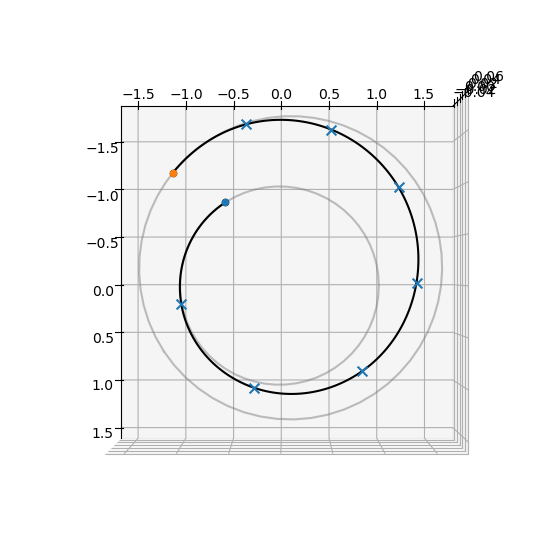

In [15]:
ax = udp_g.plot(xs[best_idx], show_gridpoints=True)
ax.view_init(90, 0)